Image Recognition
===

This notebook will create a convolutional neural network to classify images in either the mnist or cifar-10 datasets.

In [1]:
#!pip install tensorflow

# Tensorflow and numpy to create the neural network
import tensorflow as tf
import numpy as np

# Matplotlib to plot info to show our results
import matplotlib.pyplot as plt

# OS to load files and save checkpoints
import os

%matplotlib inline

Loading the data
---

This code will load the dataset that you'll use to train and test the model.

The code provided will load the mnist or cifar data from files, you'll need to add the code that processes it into a format your neural network can use.

MNIST
---

Run this cell to load mnist data.

In [2]:
# Load MNIST data from tf examples

image_height = 28
image_width = 28

color_channels = 1

model_name = "mnist"

mnist = tf.contrib.learn.datasets.load_dataset("mnist")

train_data = mnist.train.images
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)

eval_data = mnist.test.images
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)

category_names = list(map(str, range(10)))

# TODO: Process mnist data
print(train_data.shape)
train_data = np.reshape(train_data, (-1, image_height, image_width, color_channels))
print(train_data.shape)
eval_data = np.reshape(eval_data, (-1, image_height, image_width, color_channels))

W0702 22:39:26.656509  4652 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0702 22:39:26.662491  4652 deprecation.py:323] From <ipython-input-2-5594525bf945>:10: load_dataset (from tensorflow.contrib.learn.python.learn.datasets) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.data.
W0702 22:39:26.663490  4652 deprecation.py:323] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\contrib\learn\python\learn\datasets\__init__.py:80: load_mnist (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternat

Extracting MNIST-data\train-images-idx3-ubyte.gz


W0702 22:39:26.924789  4652 deprecation.py:323] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\contrib\learn\python\learn\datasets\mnist.py:267: extract_labels (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.data to implement this functionality.
W0702 22:39:26.970667  4652 deprecation.py:323] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\contrib\learn\python\learn\datasets\mnist.py:290: DataSet.__init__ (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz
(55000, 784)
(55000, 28, 28, 1)


CIFAR-10
---

Run this cell to load cifar-10 data

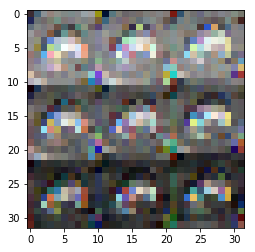

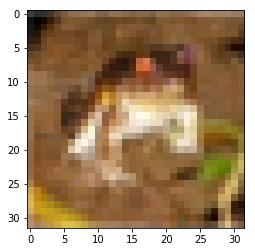

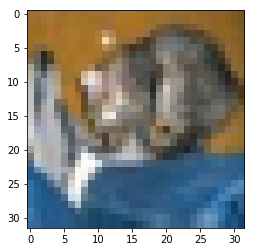

In [3]:
# Load cifar data from file

image_height = 32
image_width = 32

color_channels = 3

model_name = "cifar"

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

cifar_path = './cifar-10-data/'

train_data = np.array([])
train_labels = np.array([])

# Load all the data batches.
for i in range(1,6):
    data_batch = unpickle(cifar_path + 'data_batch_' + str(i))
    train_data = np.append(train_data, data_batch[b'data'])
    train_labels = np.append(train_labels, data_batch[b'labels'])


# Load the eval batch.
eval_batch = unpickle(cifar_path + 'test_batch')

eval_data = eval_batch[b'data']
eval_labels = eval_batch[b'labels'] 

# Load the english category names.
category_names_bytes = unpickle(cifar_path + 'batches.meta')[b'label_names']
category_names = list(map(lambda x: x.decode("utf-8"), category_names_bytes))

# TODO: Process Cifar data
def process_data_when_RGB_are_seperated(data):
    float_data = np.array(data, dtype=float) / 255.0
    reshaped_data = np.reshape(float_data, (-1, image_height, image_width, color_channels)) #ops, before transpose
    plt.imshow(reshaped_data[0])
    plt.show()

def process_data(data):
    float_data = np.array(data, dtype=float) / 255.0
    reshaped_data = np.reshape(float_data, (-1, color_channels, image_height, image_width))
    transposed_data = np.transpose(reshaped_data, [0, 2, 3, 1])
    plt.imshow(transposed_data[0])
    plt.show()
    return transposed_data


process_data_when_RGB_are_seperated(train_data)
train_data = process_data(train_data)

#the photo doesn't matter cause it's another photo from the eval set, not related to frog
eval_data = process_data(eval_data)

Once the data is processed, you have a few variables for the data itself and info about its shape:

### Model Info

- **image_height, image_width** - The height and width of the processed images
- **color_channels** - the number of color channels in the image. This will be either 1 for grayscale or 3 for rgb.
- **model_name** - either "cifar" or "mnist" - if you need to handle anything differently based on the model, check this variable.
- **category_names** - strings for each category name (used to print out labels when testing results)

### Training Data

- **train_data** - the training data images
- **train_labels** - the labels for the training data - the "answer key"

### Evaluation Data

- **eval_data** - Image data for evaluation. A different set of images to test your network's effectiveness.
- **eval_labels** - the answer key for evaluation data.

Building the Neural Network Model
--

Next, you'll build a neural network with the following architecture:

- An input placeholder that takes one or more images.
- 1st Convolutional layer with 32 filters and a kernel size of 5x5 and same padding
- 1st Pooling layer with a 2x2 pool size and stride of 2
- 2nd Convolutional layer with 64 filters and a kernel size of 5x5 and same padding
- 2nd Pooling layer with a 2x2 pool size and stride of 2
- Flatten the pooling layer
- A fully connected layer with 1024 units
- A dropout layer with a rate of 0.4
- An output layer with an output size equal to the number of labels.

In [ ]:
# TODO: The neural network
class ConvNet:
    
    def __init__(self, image_height, image_width, channels, num_classes):
        
        self.input_layer = tf.placeholder(dtype=tf.float32, shape=[None, image_height, image_width, channels], name="inputs")
        print(self.input_layer.shape)
        
        conv_layer_1 = tf.layers.conv2d(self.input_layer, filters=32, kernel_size=[5, 5], padding="same", activation=tf.nn.relu)
        print(conv_layer_1.shape)
        
        pooling_layer_1 = tf.layers.max_pooling2d(conv_layer_1, pool_size=[2,2], strides=2)
        print(pooling_layer_1.shape)
        
        conv_layer_2 = tf.layers.conv2d(pooling_layer_1, filters=64, kernel_size=[5, 5], padding="same", activation=tf.nn.relu)
        print(conv_layer_2.shape)
        
        pooling_layer_2 = tf.layers.max_pooling2d(conv_layer_2, pool_size=[2, 2], strides=2)
        print(pooling_layer_2.shape)
        
        flattened_pooling = tf.layers.flatten(pooling_layer_2)
        dense_layer = tf.layers.dense(flattened_pooling, 1024, activation=tf.nn.relu)
        print(dense_layer.shape)
        dropout = tf.layers.dropout(dense_layer, rate=0.4, training=True)
        outputs = tf.layers.dense(dropout, num_classes)
        print(outputs.shape)
        
        self.choice = tf.argmax(outputs, axis=1)
        self.probability = tf.nn.softmax(outputs)
        
        self.labels = tf.placeholder(dtype=tf.float32, name="labels")
        self.accuracy, self.accuracy_op = tf.metrics.accuracy(self.labels, self.choice)
        
        one_hot_labels = tf.one_hot(indices=tf.cast(self.labels, dtype=tf.int32), depth=num_classes)     
        self.loss = tf.losses.softmax_cross_entropy(onehot_labels=one_hot_labels, logits=outputs)
        
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=1e-2)
        self.train_operation = optimizer.minimize(loss=self.loss, global_step=tf.train.get_global_step())

The Training Process
---

The cells below will set up and run the training process.

- Set up initial values for batch size, training length.
- Process data into batched datasets to feed into the network.
- Run through batches of training data, update weights, save checkpoints.

In [ ]:
# TODO: initialize variables
training_steps = 20000
batch_size = 64

path = "./" + model_name + "-cnn/"

load_checkpoint = False
performance_graph = np.array([])

In [ ]:
# TODO: implement the training loop
tf.reset_default_graph()

dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
dataset = dataset.shuffle(buffer_size=train_labels.shape[0])
dataset = dataset.batch(batch_size)
dataset = dataset.repeat()

dataset_iterator = dataset.make_one_shot_iterator()
next_element = dataset_iterator.get_next()

cnn = ConvNet(image_height,image_width,color_channels,10)

saver = tf.train.Saver(max_to_keep=2)

if not os.path.exists(path):
    os.makedirs(path)
    
with tf.Session() as sess:
    
    if load_checkpoint:
        checkpoint = tf.train.get_checkpoint_state(path)
        saver.restore(sess, checkpoint.model_checkpoint_path)
    else:
        sess.run(tf.global_variables_initializer())
    
    sess.run(tf.local_variables_initializer())
    sess.run(dataset_iterator.initializer)
    for step in range(training_steps):
        current_batch = sess.run(next_element)
        
        batch_inputs = current_batch[0]
        batch_labels = current_batch[1]
        
        sess.run((cnn.train_operation, cnn.accuracy_op), feed_dict={cnn.input_layer:batch_inputs, cnn.labels:batch_labels})
        
        if step % 10 == 0:
            performance_graph = np.append(performance_graph, sess.run(cnn.accuracy))
        
        if step % 1000 == 0 and step > 0:
            current_acc = sess.run(cnn.accuracy)
            print("Accuracy at step " + str(step) + ": " + str(current_acc))
            print("Saving checkpoint")
            saver.save(sess, path + model_name, step)
        
    print("Saving final checkpoint for training session.")
    saver.save(sess, path + model_name, step)

W0702 22:39:55.710193  4652 deprecation.py:323] From <ipython-input-6-3c77c1dbe0c2>:9: DatasetV1.make_one_shot_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.
W0702 22:41:08.272518  4652 deprecation.py:323] From <ipython-input-4-fcc9d25823f3>:9: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
W0702 22:41:08.394193  4652 deprecation.py:506] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future vers

(?, 32, 32, 3)


W0702 22:41:09.450066  4652 deprecation.py:323] From <ipython-input-4-fcc9d25823f3>:12: max_pooling2d (from tensorflow.python.layers.pooling) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
W0702 22:41:09.606647  4652 deprecation.py:323] From <ipython-input-4-fcc9d25823f3>:21: flatten (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.flatten instead.


(?, 32, 32, 32)
(?, 16, 16, 32)
(?, 16, 16, 64)
(?, 8, 8, 64)


W0702 22:41:10.304784  4652 deprecation.py:323] From <ipython-input-4-fcc9d25823f3>:22: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0702 22:41:10.548144  4652 deprecation.py:323] From <ipython-input-4-fcc9d25823f3>:24: dropout (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dropout instead.
W0702 22:41:10.728626  4652 deprecation.py:323] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\losses\losses_impl.py:121: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


(?, 1024)
(?, 10)


Evaluating Performance
---

These cells will evaluate the performance of your network!

In [ ]:
# TODO: Display graph of performance over time
plt.plot(performance_graph)
plt.figure().set_facecolor('white')
plt.xlabel("Steps")
plt.ylabel("Accuracy")

In [ ]:
# TODO: Run through the evaluation data set, check accuracy of model

In [ ]:
# TODO: Get a random set of images and make guesses for each

# keras

In [2]:
import keras
import matplotlib.pyplot as plt
import numpy as np

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout
from keras.layers import Flatten

model = Sequential()
model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (28, 28, 1))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2))
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(rate = 0.3))
model.add(Dense(10, activation = 'softmax'))
model.summary()
          
model.compile(loss = keras.losses.categorical_crossentropy, optimizer = keras.optimizers.Adadelta())
          


SyntaxError: invalid syntax (<ipython-input-2-761d86b41a7b>, line 14)

In [4]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

model.fit(x_train, y_train, epochs = 5, batch_size = 64)

ModuleNotFoundError: No module named 'keras'